In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from autoemulate.compare import AutoEmulate
from sklearn.metrics import r2_score

from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.flow_functions import FlowProblem
from ModularCirc import BatchRunner
import json

show_progress = False if os.getenv("JUPYTER_BOOK_BUILD", "false").lower() == "true" else True

In [2]:
# Load the simulation input parameters and summary statistics

n_samples = 32768

sim_path = f'./outputs/simulations/output_{n_samples}_samples/'

# Load the simulation input parameters
input_params = pd.read_csv(os.path.join(sim_path, f'input_samples_{n_samples}.csv'))

# Load the boolean mask for failed simulations
with open(os.path.join(sim_path, 'bool_indices.json'), 'r') as f:
    bool_indices = json.load(f)

# Load the summary statistics
summary_stats = pd.read_csv(os.path.join(sim_path, f'simulations_summary.csv'))

# Load the input parameters
parameters_json_file = 'parameters_01.json'

In [3]:
# Use ModularCirc's BatchRunner to condense parameter names. This requires setting up the sampler first.
br = BatchRunner()

br.setup_sampler(parameters_json_file)

br._parameters_2_sample

{'ao.r': (120.0, 360.0),
 'ao.c': (0.15, 0.44999999999999996),
 'art.r': (562.5, 1687.5),
 'art.c': (1.5, 4.5),
 'ven.r': (4.5, 13.5),
 'ven.c': (66.65, 199.95000000000002),
 'av.r': (3.0, 9.0),
 'mv.r': (2.05, 6.1499999999999995),
 'la.E_pas': (0.22, 0.66),
 'la.E_act': (0.225, 0.675),
 'la.v_ref': (5.0, 15.0),
 'la.k_pas': (0.01665, 0.07500000000000001),
 'lv.E_pas': (0.5, 1.5),
 'lv.E_act': (1.5, 4.5),
 'lv.v_ref': (5.0, 15.0),
 'lv.k_pas': (0.00999, 0.045),
 'T': (300.0, 1200.0),
 'v_tot': (3500.0, 6500.0)}

In [4]:
# Get column names for parameters up to 'T'
parameter_names = list(input_params.columns[:input_params.columns.get_loc('T') + 1])

input_params[parameter_names]

,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,la.v_ref,la.k_pas,lv.E_pas,lv.E_act,lv.v_ref,lv.k_pas,T
0,324.140512,0.429410,970.557289,2.593650,5.759509,141.391649,5.535208,3.645771,0.302181,0.614511,13.751520,0.074688,1.310537,3.983934,10.192377,0.040153,458.957450
1,213.211374,0.168363,1134.582900,3.092750,11.457833,81.051107,6.337772,5.927350,0.476733,0.449234,6.030600,0.032403,0.538215,2.789425,7.998957,0.014420,1177.644680
2,128.027561,0.373035,664.791603,1.807716,9.775524,110.934879,3.831676,4.690519,0.657067,0.244713,9.303856,0.023797,1.070499,3.257826,7.055576,0.027896,771.390037
3,287.120769,0.262023,1448.888220,3.761496,8.444797,167.239972,7.529157,2.905174,0.338195,0.522401,10.791995,0.054236,0.830979,2.014983,14.871574,0.027224,590.140139
4,261.317508,0.322630,1342.111306,4.190009,7.184780,154.969280,3.238999,4.237066,0.583734,0.372392,7.797148,0.048891,1.195902,2.575591,12.781972,0.020054,650.410479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32763,261.324564,0.247880,1446.604723,2.214788,10.530614,73.004869,5.634851,3.861267,0.223039,0.322015,12.167113,0.074330,0.753719,1.511358,7.613490,0.019281,1091.429519
32764,287.113076,0.336760,1344.634831,1.799275,9.839534,118.995979,7.392277,5.332983,0.478891,0.586845,8.931797,0.065110,1.150117,2.821347,9.742196,0.025907,1031.983181
32765,128.034925,0.298367,1050.560774,3.787390,8.502783,191.955432,5.089326,3.543833,0.295942,0.421653,11.203113,0.041985,0.878313,3.904584,11.926159,0.028663,316.365148
32766,213.218845,0.393031,1662.906132,2.608556,5.703695,165.587503,8.723170,2.234180,0.342428,0.273293,14.160636,0.028817,1.480918,2.123627,12.854898,0.015736,732.725603


In [5]:
# Drop all the rows from input_params that correspond to entries in bool_indices
input_params = input_params.drop(bool_indices)

In [6]:
Y = summary_stats['p_ao_mean'].values

In [7]:
em = AutoEmulate()
em.setup(X = input_params[parameter_names], 
         y = Y, 
         models = ['gp'],
         n_jobs=-1)

,Values
Simulation input shape (X),"(32640, 17)"
Simulation output shape (y),"(32640,)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Scale output data (scale_output),True
Scaler output (scaler_output),StandardScaler
Do hyperparameter search (param_search),False
Reduce input dimensionality (reduce_dim),False
Reduce output dimensionality (reduce_dim_output),False


In [8]:
best_model = em.compare()

Cross-validating:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
em.summarise_cv()

,preprocessing,model,short,fold,rmse,r2
0,None,GaussianProcess,gp,3,41.268941,0.517871
1,None,GaussianProcess,gp,1,41.386519,0.509337
2,None,GaussianProcess,gp,4,41.508498,0.505608
3,None,GaussianProcess,gp,2,42.080669,0.493227
4,None,GaussianProcess,gp,0,41.849309,0.489262


In [10]:
gp = em.get_model("GaussianProcess")
em.evaluate(gp)

,model,short,preprocessing,rmse,r2
0,GaussianProcess,gp,None,30.6433,0.7209


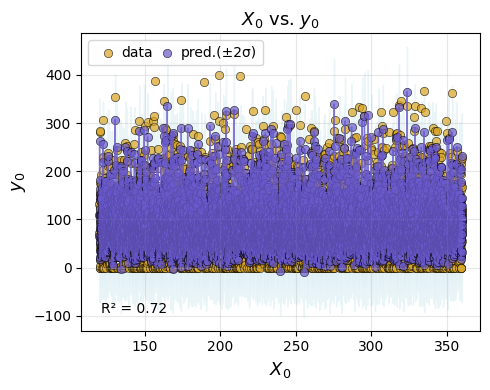

In [11]:
em.plot_eval(gp)

In [12]:
best_emulator = em.refit(gp)

In [13]:
# Extract parameter names and bounds from the dictionary
parameters_range = br._parameters_2_sample

# Drop the 'v_tot' parameter if it exists
if 'v_tot' in parameters_range:
    del parameters_range['v_tot']

parameters_range

{'ao.r': (120.0, 360.0),
 'ao.c': (0.15, 0.44999999999999996),
 'art.r': (562.5, 1687.5),
 'art.c': (1.5, 4.5),
 'ven.r': (4.5, 13.5),
 'ven.c': (66.65, 199.95000000000002),
 'av.r': (3.0, 9.0),
 'mv.r': (2.05, 6.1499999999999995),
 'la.E_pas': (0.22, 0.66),
 'la.E_act': (0.225, 0.675),
 'la.v_ref': (5.0, 15.0),
 'la.k_pas': (0.01665, 0.07500000000000001),
 'lv.E_pas': (0.5, 1.5),
 'lv.E_act': (1.5, 4.5),
 'lv.v_ref': (5.0, 15.0),
 'lv.k_pas': (0.00999, 0.045),
 'T': (300.0, 1200.0)}

In [14]:
parameter_names = list(parameters_range.keys())
parameter_bounds = list(parameters_range.values())

# Define the problem dictionary for Sobol sensitivity analysis
problem = {
    'num_vars': len(parameter_names),
    'names': parameter_names,
    'bounds': parameter_bounds
}

In [15]:
df_sa = em.sensitivity_analysis(problem=problem)

17
17


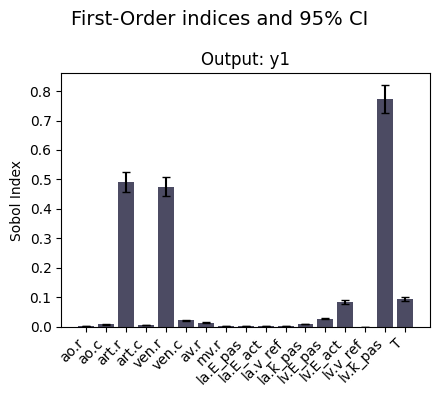

In [16]:
em.plot_sensitivity_analysis(results = df_sa)